In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from method_utils import load_dataset
from method_utils import get_generators
from method_utils import get_distances
from method_utils import get_gramian
from method_utils import normalize_distances
from method_utils import get_invariant_measures

from scipy.linalg import expm

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### Load dataset

In [194]:
# Set location to 'temporal_networks' or 'datasets' depending on the location of the dataset
dataset_name = 'opinions'
location = 'datasets'

vertices, edges, adj_matrices, labels = load_dataset(dataset_name, loc=location)

### Calculate invariant measures

In [195]:
invariant_measures = get_invariant_measures(adj_matrices)

### Compute matrix $K$

In [196]:
distances = get_distances(invariant_measures, norm=2)

Computing distances: 100%|##########| 167/167 [00:00<00:00, 1886.20it/s]


<Axes: >

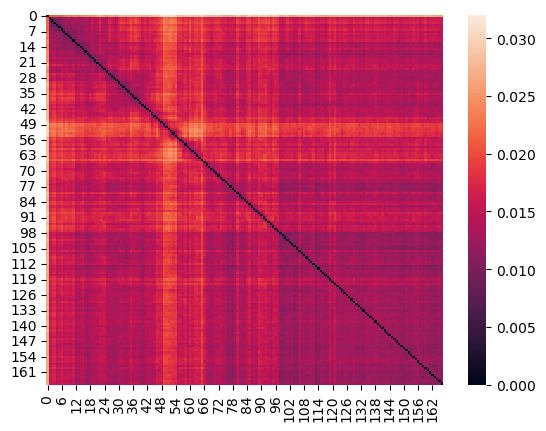

In [197]:
sn.heatmap(distances)

In [198]:
sigma = 0.01
K = get_gramian(distances, sigma)
np.fill_diagonal(K, 0)

<Axes: >

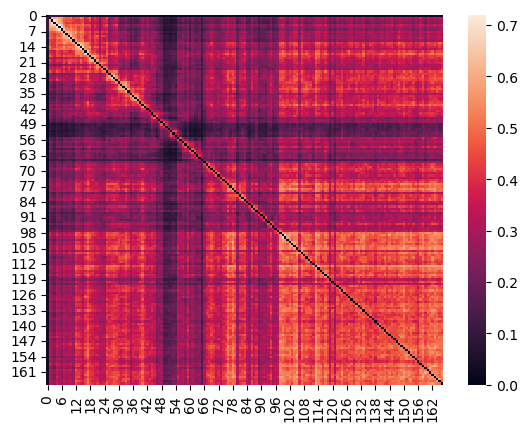

In [199]:
sn.heatmap(K)

### Compute temporal generator $L_{temp}$.

In [200]:
L_temp = get_generators(K)

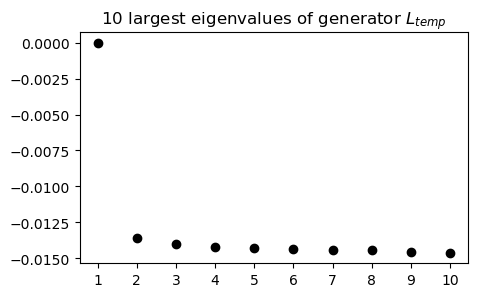

In [201]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generator $L_{temp}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

L_temp_eigvals, L_temp_eigvecs = np.linalg.eig(L_temp)
L_temp_eigvals_sorted = np.sort(L_temp_eigvals)[-10:][::-1]
plt.scatter(x=x_axis, y=L_temp_eigvals_sorted, c='black')

### Set $\tau_{temp}$ and compute $P_{temp}^{\tau_{temp}}$

In [203]:
tau_temp = 13
P_temp = expm(L_temp*tau_temp)

### Spectral clustering of $P^{\tau_{temp}}_{temp}$.

Determine dominant eigenvalues of transition matrix $P^{\tau}_{temp}$

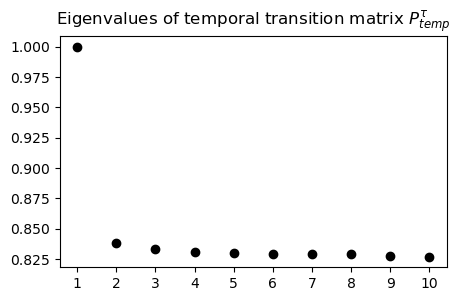

In [204]:
P_temp_eigval, P_temp_eigvec = np.linalg.eig(P_temp)
indices = np.argsort(P_temp_eigval)[-10:][::-1]
P_temp_eigval_sorted = P_temp_eigval[indices]
P_temp_eigvec_sorted = P_temp_eigvec[:, indices]

plt.figure(figsize=(5, 3))
plt.title("Eigenvalues of temporal transition matrix $P_{temp}^{\\tau}$")
plt.xticks(np.arange(1,11))
plt.scatter(np.arange(1, 11), P_temp_eigval_sorted, c='black')

Get snapshot embeddings

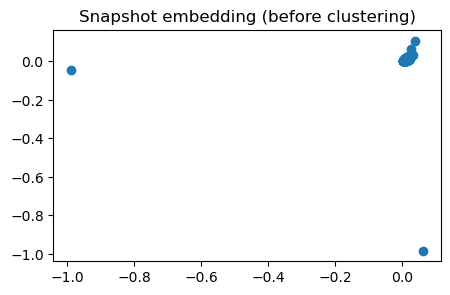

In [205]:
dominant_eigenvalues = 2

data = P_temp_eigvec_sorted[:, :dominant_eigenvalues]

plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(5,3))
plt.title("Snapshot embedding (before clustering)")
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1])


Perform spectral clustering

In [206]:
kmeans = KMeans(n_clusters=dominant_eigenvalues, random_state=0)
kmeans.fit(np.real(data))

predicted_labels = kmeans.labels_
print(predicted_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/filip/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Compute ARI score

In [207]:
ari = adjusted_rand_score(labels, predicted_labels)
print(f"ARI: {ari*100}")

ARI: -0.7109049227245514


### Get Distance matrix (IMC)

Text(0.5, 1.0, 'Distance matrix of opinions dataset; $\\sigma=0.01$, $\\tau_{temp}=13$')

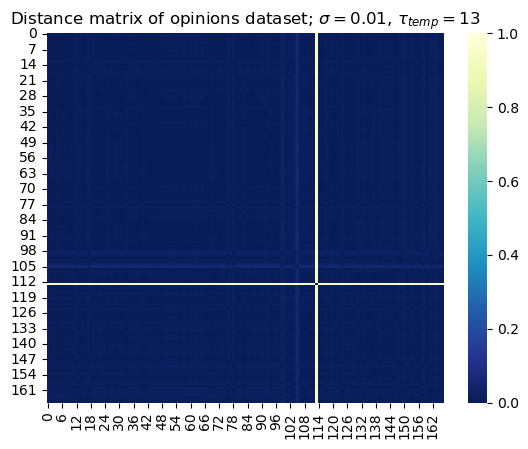

In [208]:
distance_matrix = np.zeros(shape=(len(adj_matrices), len(adj_matrices)))

for i in range(len(adj_matrices)):
    for j in range(len(adj_matrices)):
        distance_matrix[i, j] = np.linalg.norm(data[i,:] - data[j,:])

distance_matrix_norm, min_distance, max_distance = normalize_distances(distance_matrix)

ax = sn.heatmap(distance_matrix_norm, annot=False, annot_kws={"size": 16}, cmap="YlGnBu_r")
ax.set_title(f"Distance matrix of {dataset_name} dataset; $\sigma={sigma}$, $\\tau_{{temp}}={tau_temp}$")